In [44]:
import pandas as pd
import numpy as np
%matplotlib inline
import sqlite3 as lite
from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import math
con = lite.connect('census')
#data.to_sql(name='censusHH',con=con, if_exists ='append')

Run below code for once to generate dictDF.csv; For future usage run cell below it

In [ ]:
with open('PUMSDataDict13.txt') as f:
    content = f.readlines()
dictCol = pd.DataFrame(content,columns=['content'])
dictCol['spaces'] = dictCol.apply(lambda x: len(x.content)-len(str(x.content).lstrip(' ')),axis=1)
dictCol['clean_content'] = dictCol.apply(lambda x: str(x.content).strip(),axis=1)
new_df = dictCol
new_df['header'], new_df['key'], new_df['val'] = ['','','']
new_df = new_df[['header','key','val']]
for index,row in dictCol.iterrows():
    if index != dictCol.tail(1).index:
        if (row.spaces>0) & (len(row.clean_content)==0):
            new_df = new_df.drop(index)
        elif (dictCol.ix[index+1].spaces!=0) and (row.spaces==0):
            new_df.ix[index] = [row['clean_content'].split(' ')[0], 'header', row['clean_content'].split(' ')[0]]
            header = row['clean_content'].split(' ')[0]
        elif (row.spaces==4):
            new_df.ix[index] = [header, 'fullName', row['clean_content']]
        elif (row.spaces==11):
            new_df.ix[index] = [header, row['clean_content'].rsplit('.',1)[0], row['clean_content'].rsplit('.',1)[1]]
        else:
            new_df = new_df.drop(index)
new_df.to_csv('dictDF.csv')

In [ ]:
#find_dict function queries using main dataset's header
new_df = pd.read_csv('dictDF.csv',index_col=0)
div = new_df[new_df.val=='RT'].tail(1).index
dictH,dictP = new_df[new_df.index<div], new_df[new_df.index>=div]
def find_dict(keyword, arg):
    if arg=='P':
        return dictP[dictP.header==keyword]
    if arg=='H':
        return dictH[dictH.header==keyword]
a = find_dict('MIGSP','P')
a.query("key not in ('header','fullName')")

In [ ]:
#data=pd.read_csv('ss13husb.csv')

In [ ]:
states = pd.read_csv('states.csv')
states.state = states.state.apply(lambda x: x[:-3][1:])

Show features

In [ ]:
dictP[(dictP.key=='fullName')].ix[5873:7000]

In [45]:
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
with con:
 
    con.create_aggregate("stdev", 1, StdevFunc)
 
    cur = con.cursor()

In [21]:
inc_sex = pd.read_sql('select SEX, avg(PINCP) income, ST, round(PUMA/100,0)*100 as PUMA \
from censusPerson \
group by  ST, round(PUMA/100,0)*100, SEX',con=con)
inc_avg = pd.read_sql('select avg(PINCP) income, ST,round(PUMA/100,0)*100 as PUMA \
from censusPerson group by  ST, round(PUMA/100,0)*100',con=con)

In [25]:
inc_sex = pd.read_sql('select SEX, avg(PINCP) income, ST, PUMA \
from censusPerson \
group by  ST, PUMA, SEX',con=con)
inc_avg = pd.read_sql('select avg(PINCP) income, ST, PUMA \
from censusPerson group by  ST, PUMA',con=con)

In [26]:
inc_sex['ST_PUMA'] = inc_sex.apply(lambda x: str(x['ST'])+'-'+str(x['PUMA']),axis=1)
inc_avg['fIncome'] = inc_sex.pivot(columns='SEX',index='ST_PUMA')['income',2].values
inc_avg['mIncome'] = inc_sex.pivot(columns='SEX',index='ST_PUMA')['income',1].values
inc_avg['diff'] = (inc_avg.fIncome-inc_avg.mIncome)
#age_sex['mIncome'] = age_sex.pivot(columns='SEX',index='ST_PUMA')['avg(PINCP)',1]
%store inc_sex
%store inc_avg

Stored 'inc_sex' (DataFrame)
Stored 'inc_avg' (DataFrame)


In [36]:
inc_avg['less'] = inc_avg['diff'] / inc_avg['income']
inc_avg['value'] = inc_avg['less'].rank(ascending=True)/inc_avg.income.count()
inc_avg.to_csv('data.csv',index=False)

In [5]:
inc_sex=pd.read_csv('inc_diff.csv',index_col=False)

In [ ]:
migration=pd.read_sql('select SEX, round(MIGPUMA/100,0)*100 MIGPUMA, \
MIGSP, ST, round(PUMA/100,0)*100 PUMA, AGEP, MAR, SCHL \
from censusPerson where \
MIGSP>0 and MIGPUMA>0 and ST>0 and PUMA>0 and not (ST=MIGSP & round(PUMA/100,0)*100=round(MIGPUMA/100,0)*100)',con=con)

In [ ]:
temp.head()

In [ ]:
temp = migration.merge(inc_avg,on=['ST','PUMA'])
temp = temp.drop(['ST','PUMA','value'],axis=1)
temp.columns=['SEX','PUMA','ST','age','mar','edu','emp','income','fIncome','mIncome','diff']
#temp.PUMA=temp.PUMA.apply(lambda x: round(x/100.0,0)*100)
temp.head()
from_to = temp.merge(inc_avg,on=['ST','PUMA'])

In [ ]:
#x is to, y is from
from_to['fIncrease'] = from_to['fIncome_x']-from_to['fIncome_y']
from_to['eIncrease'] = from_to['diff_x']-from_to['diff_y']
from_to = from_to[(from_to.fIncrease!=0)&(from_to.eIncrease!=0)]
from_to = from_to.ix[:,[0,1,2,3,4,5,16,17,18]]
from_to.to_csv('migration.csv',index_col=False)

In [ ]:
from_to['age_bucket'] = from_to.age.apply(lambda x: 'working' if x<60 else 'retired')
from_to['edu_bucket'] = from_to.edu.apply(lambda x: 'highschool' if x<=21 else 'college')
from_to['mar_bucket'] = from_to.mar.apply(lambda x: 'married' if x==1 else 'single')

In [ ]:
lower = from_to[(from_to.edu_bucket==1)&(from_to.SEX==2)]
higher = from_to[(from_to.edu_bucket==2)&(from_to.SEX==2)]
#male.fIncrease.describe()

In [ ]:
lower.eIncrease.describe()

In [ ]:
higher.eIncrease.describe()

In [ ]:
def puma_lookup(puma, st):
    m = Basemap(width=5000000,height=3500000,\
            resolution='l',projection='aea',\
            lat_1=30.,lat_2=50,lon_0=-96,lat_0=38)
    m.readshapefile('../shapefiles/pums/tl_2013_%02d_puma10' %st,\
                    name='state', drawbounds=True, default_encoding='latin-1')
    result = pd.DataFrame(m.state_info)
    return str(result[result.PUMACE10=="%05d" % puma]['NAMELSAD10'].values)
puma_lookup(101,10)

In [ ]:
female=from_to[from_to.SEX==1]
female.groupby(['age_bucket','mar_bucket','edu_bucket']).fIncrease.mean()

In [ ]:
female=from_to[from_to.SEX==2]
female.groupby(['edu']).fIncrease.mean()

In [ ]:
from_to.to_csv('migration.csv',index_col=False)

In [ ]:
from_to.head()

In [ ]:
main_plot = lower.plot(x='fIncrease',y='eIncrease',kind='scatter')

In [ ]:
lrplot = sns.regplot(data=inc_avg,x='fIncome',y='diff',marker='.')
#lrplot.set(xlim=(-50000, 50000), ylim=(-50000, 50000))
#lrplot.plot(x=sample_data.fIncrease,y=sample_data.eIncrease,kind='scatter')

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
x=inc_avg['fIncome']
y=inc_avg['diff']
universe = lr.fit(x[:,np.newaxis],y)
print('Coefficients: \n', lr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lr.predict(x[:,np.newaxis]) - y) ** 2))

In [ ]:
lr = linear_model.LinearRegression()
x=female.fIncrease
y=female.eIncrease
universe = lr.fit(x[:,np.newaxis],y)
print('Coefficients: \n', lr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lr.predict(x[:,np.newaxis]) - y) ** 2))

In [ ]:
lr = linear_model.LinearRegression()
x=male.fIncrease
y=male.eIncrease
universe = lr.fit(x[:,np.newaxis],y)
print('Coefficients: \n', lr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lr.predict(x) - y) ** 2))

In [ ]:
import seaborn as sns
sns.jointplot(x="fIncrease", y="eIncrease", data=sample_data)

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(retired.fIncrease,retired.eIncrease, cmap=cmap, n_levels=60, shade=False,shade_lowest=True);

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(working.fIncrease,working.eIncrease, cmap=cmap, n_levels=60, shade=False,shade_lowest=True);

In [ ]:
sample_data.to_csv('sample_data.csv',index_col=False)

In [46]:
inc_avg = pd.read_sql('select stdev(PINCP) value, ST, PUMA \
from censusPerson group by  ST, PUMA',con=con)
inc_avg.to_csv('data.csv',index=False)

Run plotting script, first arg = file name without ext (.csv), second arg = number of states to plot (50 to plot full map)

In [53]:
%run plot.py data 50

plot.py:110: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  pc.set_color(blues[bucket])


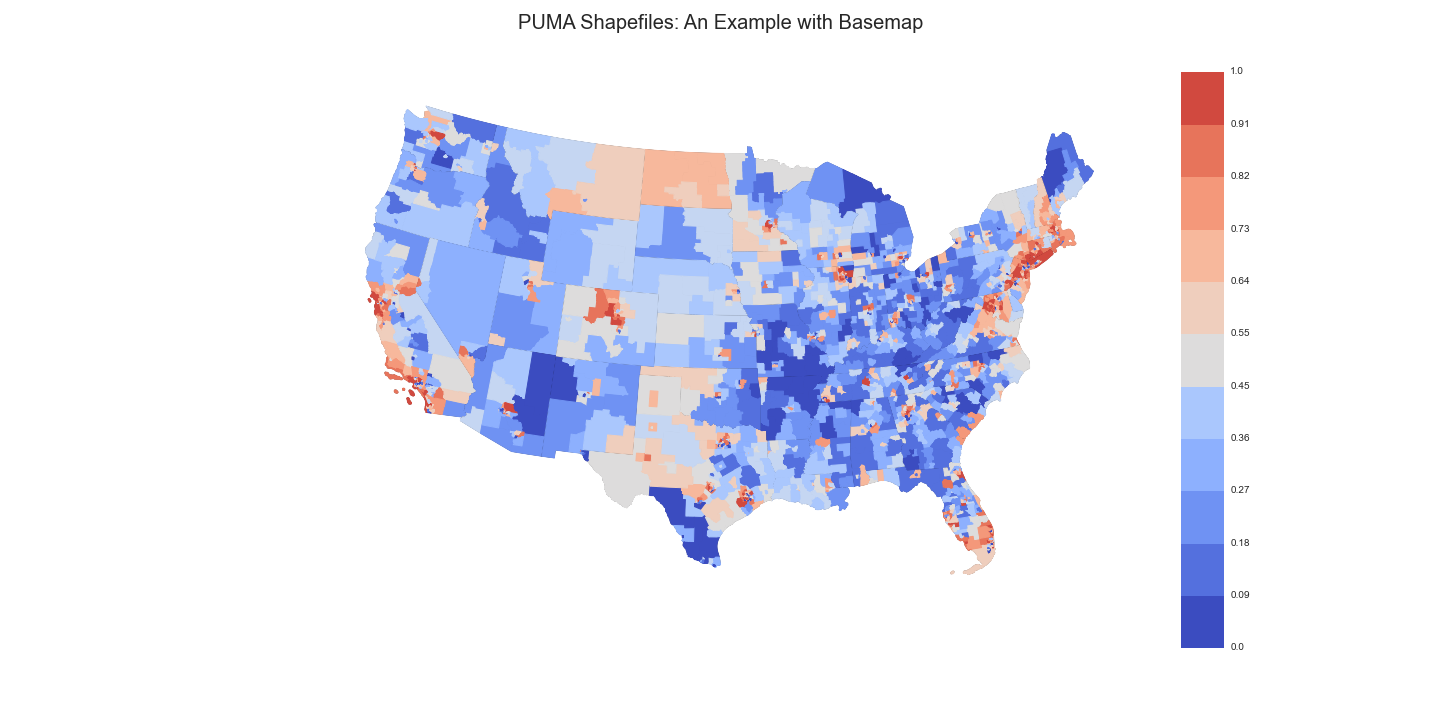

In [54]:
from IPython.display import Image
Image(filename='map.png')

In [55]:
inc_avg.head()

,value,ST,PUMA
0,0.076989,1,100
1,0.483199,1,200
2,0.629945,1,301
3,0.786048,1,302
4,0.138239,1,400


In [ ]:
sys.argv[2]